In [1]:
import arango
import lem_functions_2 as lf
import lem_classes as lc

In [2]:
import sys
import os
import json,ast
from pandas import DataFrame
import itertools
import math
import numpy as np
import random
import json

In [52]:
# connect to db
user_db = arango.UserDB()
user_db.connect()

mapid = "57718789"
sample_size=10000

# output to R
luc_changes=[]
luc_matrix=[]

# get map by id
map_json=user_db.get_map(mapid,rawResults=True)
init_map=map_json

#j = json.dumps(reps)
map_id_json = mapid + ".json"
with open(map_id_json, 'w') as f:
    json.dump(map_json, f)
    
d = json.dumps(init_map)
init_map_name = mapid + "_init_map.json"
with open(init_map_name, "w") as c:
    c.write(d)
    c.close()

biome = map_json["biome"]
# extract information about stakeholders (representatives)
reps = []
for i in map_json['indicators']:
    iCount = 0
    for s in i['stakeholders']:
        reps.append({
            'isx': iCount,
            'Representative': len(reps),
            'Name': str(s['name']),
            "Indicator": str(i['key']),
            "Direction": str(s['direction']).capitalize(),
            "Threshold": s['threshold']
        })
        iCount += 1

j = json.dumps(reps)
reps_map_name = mapid + "_reps.json"
with open(reps_map_name, 'w') as f:
    f.write(j)
    f.close()

# create a list of parcels indexed by lucs
matrix = {}
parcels = {}
for l in map_json["lucs"]:
    parcels[l["zone"]] = {
        'area': 0,
        'parcels': 0,
        'name': l["name"]
    }
    matrix[l['name']] = l['multipliers']
# put parcels with the same luc together, not sure if this is necessary
parcel_set = set()
for p in map_json['parcels']:
    #pKey = p['properties'][Config.get("parcel_keys", "LUC")]
    pKey = p['properties']['LUC']
    #parcels[pKey]['area'] += float(p['properties'][Config.get("parcel_keys", "AREA")])
    #parcel_area = float(p['properties'][Config.get("parcel_keys", "AREA")])
    parcel_area = float(p['properties']['Area'])
    parcels[pKey]['area'] += parcel_area
    parcels[pKey]['parcels'] += 1
    parcel_set.add(lc.Parcel(len(parcel_set), parcel_area ,parcels[pKey]["name"]))
parcelValues = parcels.values()
matrixA = DataFrame.from_dict(matrix).transpose()
#
stakeholders = reps
input_parcels = parcelValues
n_randomallocations = sample_size
# get reps
representatives = []
for i in range(len(stakeholders)):
    rep_json = stakeholders[i]
    rp = lc.Representative(rep_json, matrixA, i)
    rp.threshold=rep_json['Threshold']
    representatives.append(rp)
lf.read_map(input_parcels)

parcels0 = parcel_set
# init_map_file = open("init_map.txt","w")
# init_map_file.write ("parcle_id\tarea\tluc\n")
# for p in parcels0:
#     init_map_file.write(str(p.ix) +"\t"+str(p.area)+"\t"+p.land_use+"\n")
#  init_map_file.close()

# init map luc area
lc.Allocation.initial_allocation = lc.Allocation(parcels0)
lc.Allocation.all_lucs = list(matrixA.index) 
lc.Allocation.parcels0 = sorted(parcels0, key=lambda x: x.area)
lc.Allocation.p_areas_prop = [p.area / lc.Allocation.total_area for p in lc.Allocation.parcels0]

num_of_parcels = len(parcels0)
npc_min = 5 # min number of parcel changes
npc_max = 0.2*num_of_parcels # max number of parcel changes
npc_mean = 0.1*num_of_parcels # mean number of parcel changes
npc_sd = 0.25*num_of_parcels   # standard deviation of number of parcel changes
 
# start simulation
# luc_changes will have format like luc_0_0:1;luc_0_1:2;...upto luc_10_10
allocations2 = []
allocations2.append(lc.Allocation(parcels0))
allocations2[0].aix = itertools.count(1)
n_sample=sample_size

for i in range(n_sample): # sample n maps as variation of initial map
        # determine the number of parcles to change
    k = int(math.ceil(np.random.normal(npc_mean,npc_sd))) 
    if k<npc_min:
        k=npc_min
    if k>npc_max:
        k=npc_max
        # generate a map with k parcels LUC changed and add to the sample
    allocations2.append(lc.Allocation.randomAllocation_2(k, 0.005, 0.0025,0.001,0.5,i,luc_changes))

    # calculate indicator values for each allocation
lc.Allocation.n_alloc = len(allocations2)
for a in allocations2:
    a.calculate_indicators(matrixA)
    # segment indicators and compute delta sets for each rep
#Indicator.createIndicators2(allocations2)
    # compute stakeholder satisfactory
    #stakeholder_file = open("stakeholder.txt","w")
    #stakeholder_file.write("stakeholder\tindicator\tthreshold\tinit_value\tdirection\tinit_map_satisfied\n")

for k in range(len(allocations2)):
    for i in range(len(representatives)):
        rp = representatives[i]
        s = stakeholders[i]
        indicator_value = allocations2[k].indicators[s["Indicator"]]
        satisfied = "NO"
        if s["Direction"]=="Higher" and indicator_value[0]>rp.threshold:
            satisfied = "Yes"
        elif s["Direction"]=="Lower" and indicator_value[0]<rp.threshold:
            satisfied = "Yes" 
        luc_matrix.append({
            'mapid':k,
            'stakeholder':s["Name"],
            'satisfied':satisfied,
            'indicator':s["Indicator"],
            'indicator_value':indicator_value[0],
            'threshold':rp.threshold,
            'direction':s["Direction"]
        })

In [53]:
sh_satis = []
mapind = -1
cnt = 0
for i in range(len(luc_matrix)):
    if i != 0 and luc_matrix[i]["mapid"] != mapind:
        sh_satis.append(cnt)
        mapind = luc_matrix[i]["mapid"]
        cnt = 0
    if luc_matrix[i]["satisfied"] == "Yes":
        cnt += 1

In [54]:
mapinds = list(range(1,len(sh_satis)+1))
mapinds[-1]

10001

In [15]:
import matplotlib.pyplot as plt
import numpy as np

(array([1446.,    0., 1383.,    0., 2321.,    0., 2278.,    0., 2566.,
           7.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

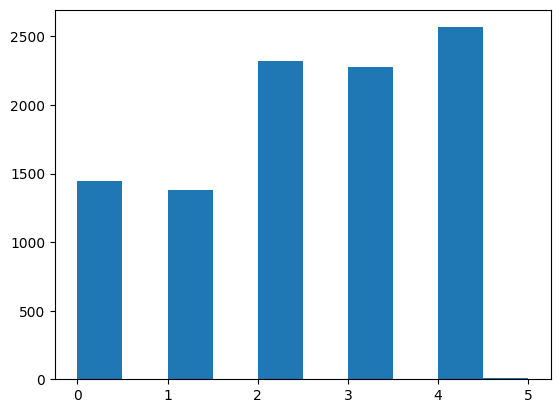

In [34]:
fig = plt.figure()
plt.hist(sh_satis)

In [35]:
fig.savefig(f'{mapid}_plot.png')

In [55]:
x = list(str(m) for m in mapinds)
y = sh_satis

# Sort the data based on y-values
sorted_indices = np.argsort(y)
sorted_x = np.array(x)[sorted_indices]
sorted_y = np.array(y)[sorted_indices]

In [29]:
sorted_x

array(['1', '4803', '4804', ..., '8352', '2436', '7530'], dtype='<U5')

In [31]:
sorted_y

array([0, 0, 0, ..., 5, 5, 5])

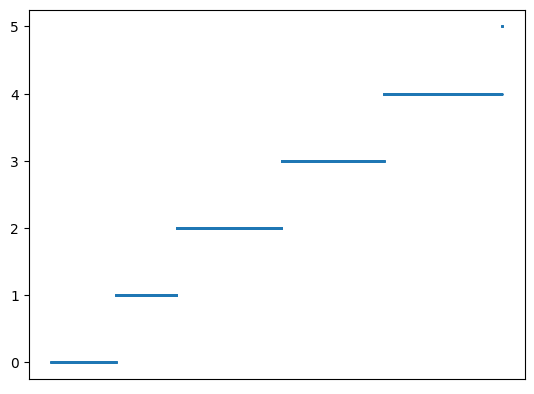

In [56]:
fig = plt.figure()
plt.scatter(sorted_x, sorted_y, s=0.5)
plt.xticks([])
plt.show()

In [57]:
fig.savefig(f'{mapid}_plot_2.png')